# **Sanity check**
### **05/26/2022**

In [38]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
from glob import glob
import torch
import cv2
import random

In [41]:
def mahalanobis_transformation(feature_df, flag = "Train"):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    if flag == "Train":
        globals()['feature_mean'] = np.array(feature_df.mean()).reshape(-1, 1).T # 1 * p
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered
        u, s, vh = np.linalg.svd(cov) # all real numbers
        # w, v = np.linalg.eig(cov) # generate complex numbers
        # theshold for pinv: 1e-15
        s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
        s_pinv_sqrt = np.array(np.zeros(feature_df.shape[1]))
        for i, item in enumerate(np.diag(s_pinv)):
            if item > 0:
                s_pinv_sqrt[i] = np.sqrt(item)
        globals()['sigma_pinv_sqrt'] = u @ np.diag(s_pinv_sqrt) @ u.T
        feature_df_whitened = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    else:
        feature_df_whitened = (feature_df - ones @ globals()['feature_mean']) @ globals()['sigma_pinv_sqrt']
    return feature_df_whitened

def my_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):

    def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_centered.shape[0]
        return cov
    
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        # get slices
        slice_index_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
        for i in np.arange(5):
            slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
            globals()["feature_df_" + str(i + 1)] = feature_df_whitened.iloc[slice_index_dict[i + 1],:]
            globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
            # get sliced cov matrices
            globals()['cov_' + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
        # concatenate 5 cov matrices, weighted by the proportion of classes
        globals()['weight_df'] = label_df["label"].value_counts() / label_df.shape[0]
        weighted_cov = pd.DataFrame(
            data = np.zeros((cov_1.shape[0], cov_1.shape[0])), 
            columns = np.arange(feature_df.shape[1], dtype = int), 
            index = globals()['cov_' + str(1)].index
        )
        for i in np.arange(5):
            print('-------------------------------------------------------------------')
            print(f'Class label {str(i + 1)}:')
            # u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            u, s, vh = np.linalg.svd((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
            print(f'(I - V)^2 eigenvalues: {s}')
            weighted_cov += weight_df.loc[i + 1] * (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T
        u, s, vh = np.linalg.svd(weighted_cov)
        print('-------------------------------------------------------------------')
        print(f'Weighted sum of (I - V)^2 eigenvalues: {s}')
        print('-------------------------------------------------------------------')
        globals()['directions'] = vh[:,:n_directions]
        feature_df_reduced = feature_df_whitened @ directions
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_reduced = feature_df_whitened @ globals()['directions']
    return feature_df_reduced

def post_process(
    feature_df, 
    label_df, 
    flag = "Train", 
    method = None, 
    add_predictors = False, 
    n_directions = 977
):
    '''
    Implement sufficient dimension reduction methods. 
    SAVE
    Contour regression
    '''
    %xmode plain
    import pandas as pd
    import re
    import os
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    if method:
        feature_df_reduced = method(
            feature_df = feature_df, 
            label_df = label_df, 
            flag = flag,
            n_directions = n_directions
        )
        feature_df_reduced = pd.DataFrame(feature_df_reduced)
        return feature_df_reduced
    else:
        print("No method specified")
        pass


In [42]:
def sanity_check(size = 1000, core_dirs = 1, core_distribution = np.random.normal, redundant_dirs = 1, n_directions = 1, **kwargs):
    core_feature_df = pd.DataFrame(data = None)
    for i in np.arange(core_dirs):
        core_feature_df = pd.concat(
            [
                core_feature_df, 
                pd.Series(core_distribution(size = size, **kwargs) * (np.random.randint(10) + 5))
            ], 
            axis = 1
        )
    core_coef = np.random.random(size = core_dirs) * 0.1
    y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
    y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
    redundant_feature_df = pd.DataFrame(data = None)
    for i in np.arange(redundant_dirs):
        redundant_feature_df = pd.concat(
            [
                redundant_feature_df, 
                pd.Series(np.random.random(size = size) * (np.random.randint(10) + 5))
            ], 
            axis = 1
        )
    fig = plt.figure(figsize = (6,6), dpi = 270)
    ax = fig.add_subplot(projection = '3d')
    ax.scatter(
        core_feature_df.iloc[:,0], 
        redundant_feature_df.iloc[:,0], 
        y_train_discrete.reshape(-1, 1), 
        cmap = "inferno", 
        s = 4, 
        linewidths = 0, 
        edgecolors = None, 
        c = y_train_discrete.reshape(-1, 1))
    ax.set_xlabel("core_x1")
    ax.set_ylabel("redundant_x1")
    ax.set_zlabel("y")
    ax.set_title("Core features: " + str(core_dirs) + " Redundant features: " + str(redundant_dirs))
    plt.show()
    plt.figure(figsize = (4, 3), dpi = 270)
    plt.scatter(core_feature_df.iloc[:,0], y_train_discrete, cmap = "inferno", c = y_train_discrete.reshape(-1, 1))
    plt.xlabel("core_x1")
    plt.ylabel("y")
    plt.title("Sectional View")
    plt.show()

    syncthetic_feature_df_train = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    syncthetic_label_df_train = pd.DataFrame(y_train_discrete, columns = ["label"])

    post_process(
        feature_df = syncthetic_feature_df_train, 
        label_df = syncthetic_label_df_train, 
        flag = "Train", 
        method = my_SAVE, 
        n_directions = n_directions
    )
    print('-------------------------------------------------------------------')
    print(f'Directions: \n{directions}')
    pass


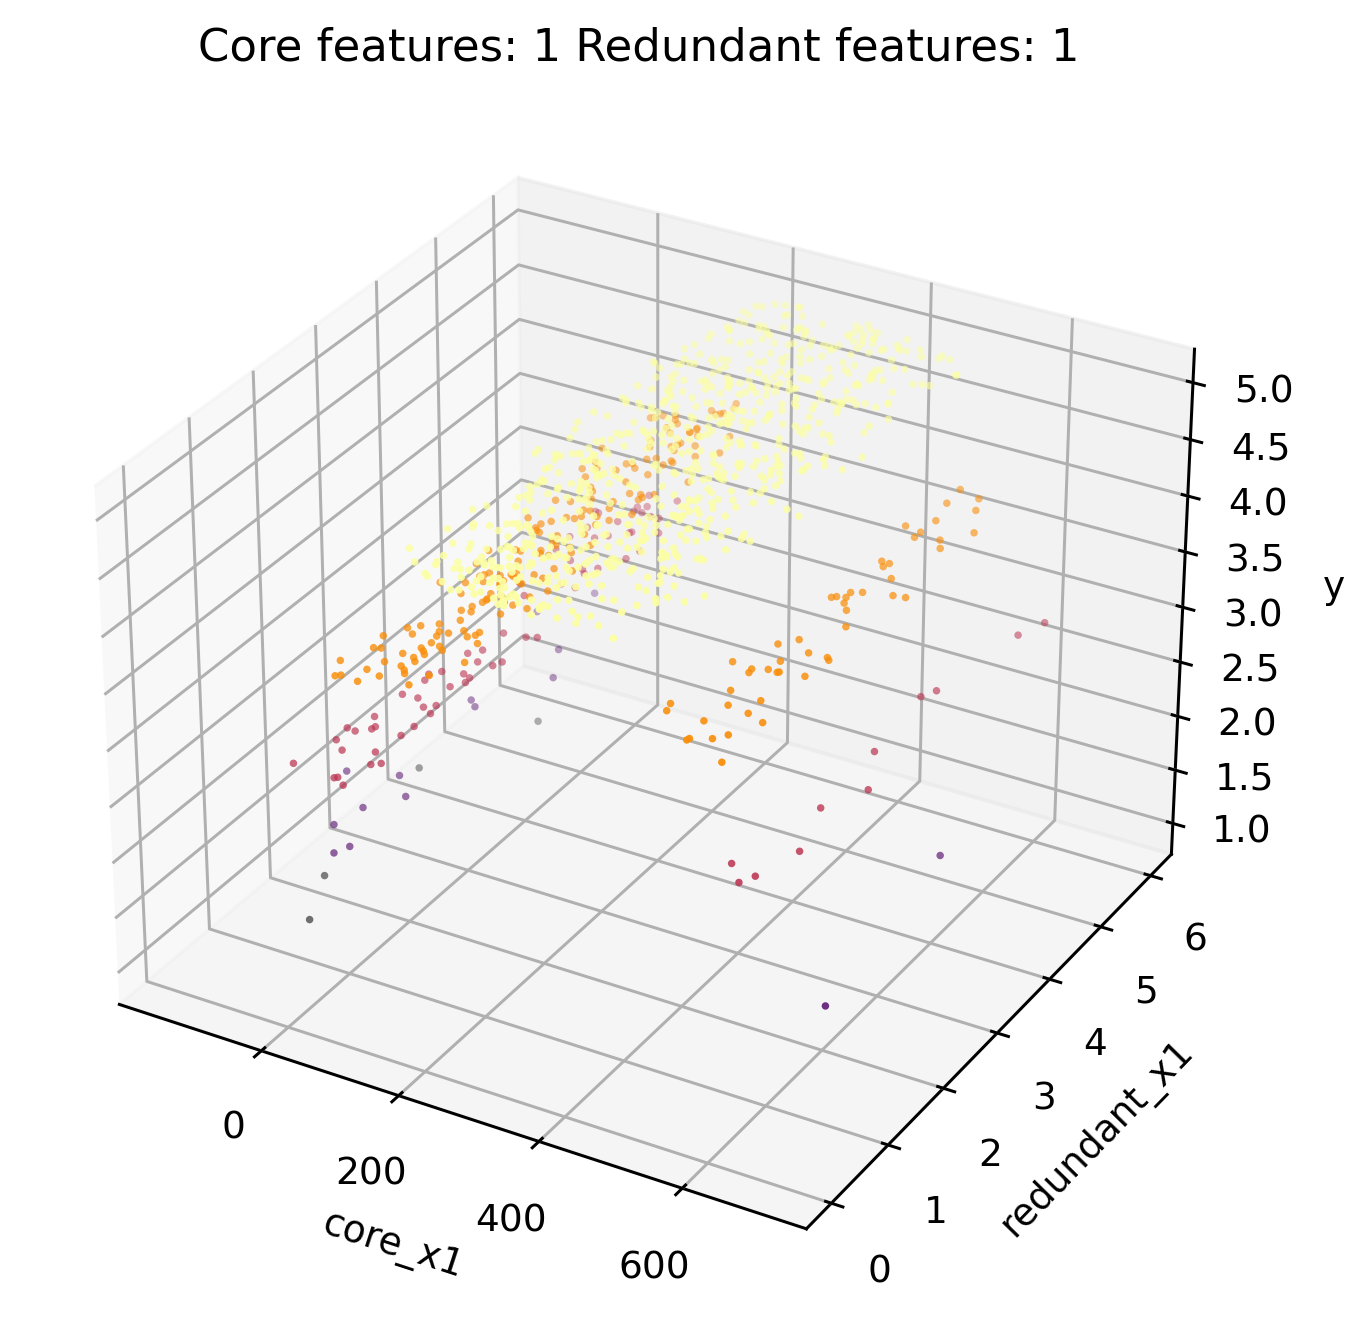

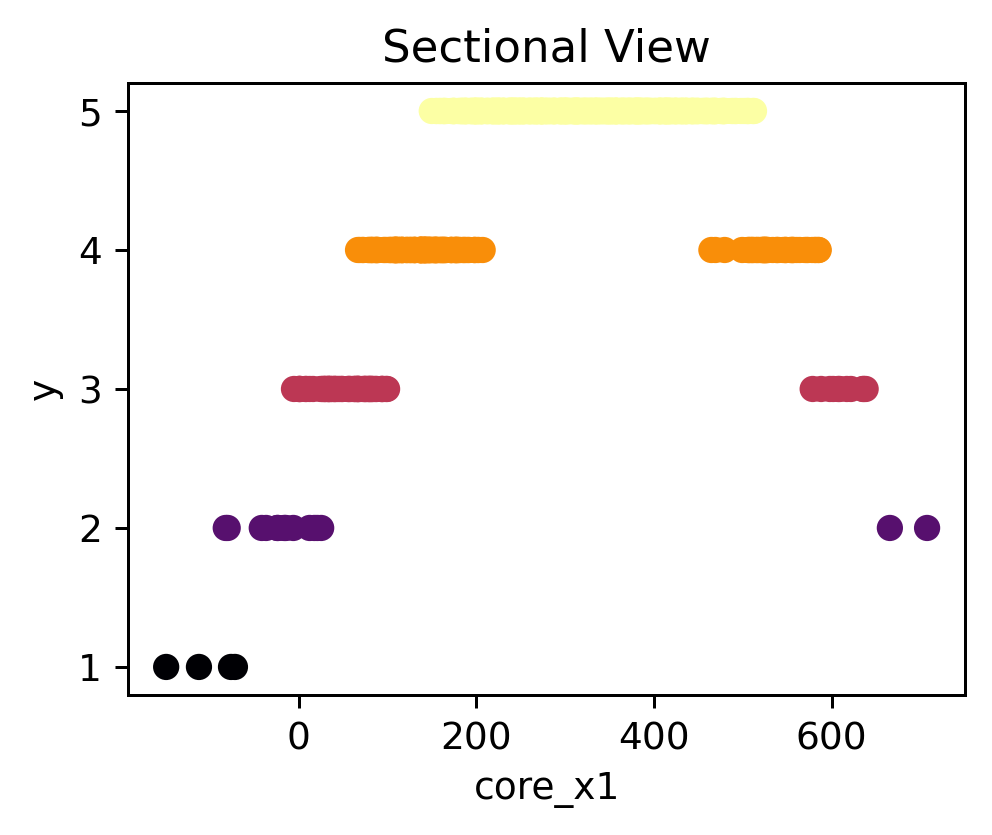

Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (1000, 2)
-------------------------------------------------------------------
Class label 1:
(I - V)^2 eigenvalues: [0.99990282 0.99826517]
-------------------------------------------------------------------
Class label 2:
(I - V)^2 eigenvalues: [0.99823222 0.99394157]
-------------------------------------------------------------------
Class label 3:
(I - V)^2 eigenvalues: [0.99766408 0.99595589]
-------------------------------------------------------------------
Class label 4:
(I - V)^2 eigenvalues: [0.99815466 0.99696705]
-------------------------------------------------------------------
Class label 5:
(I - V)^2 eigenvalues: [0.99926392 0.99799405]
-------------------------------------------------------------------
Weighted sum of (I - V)^2 eigenvalues: [0.9984557  0.99800241]
-----------------------------------------------------------------

In [43]:
sanity_check(core_dirs = 1, redundant_dirs = 1, n_directions = 2, loc = 20, scale = 10)

In [35]:
basis = directions[:3,:]
np.linalg.matrix_rank(basis)

3

In [32]:
basis

array([[-0.09032152,  0.01111316, -0.44035267],
       [ 0.60750144, -0.15626954,  0.43736235],
       [-0.14429247, -0.20615381,  0.32163029]])